In [1]:
import torch
from datasets import load_dataset
from transformers import (
    BlenderbotForConditionalGeneration,
    BlenderbotTokenizer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
)

mname = "facebook/blenderbot-400M-distill"
model = BlenderbotForConditionalGeneration.from_pretrained(mname)
tokenizer = BlenderbotTokenizer.from_pretrained(mname)

In [2]:
dataset = load_dataset("alespalla/chatbot_instruction_prompts")

Found cached dataset parquet (C:/Users/wangz/.cache/huggingface/datasets/alespalla___parquet/alespalla--chatbot_instruction_prompts-b1441363e0d6c5dd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
def preprocess_data(example):
    input_text = example["prompt"]
    output_text = example["response"]
    input_encoding = tokenizer(input_text, truncation=True, padding='max_length', max_length=128, return_tensors="pt")
    output_encoding = tokenizer(output_text, truncation=True, padding='max_length', max_length=128, return_tensors="pt")
    return {
        "input_ids": input_encoding["input_ids"],
        "attention_mask": input_encoding["attention_mask"],
        "labels": output_encoding["input_ids"],
    }


In [4]:
train_dataset = dataset["train"].map(preprocess_data, batched=True)[:1000]
val_dataset = dataset["test"].map(preprocess_data, batched=True)[:100]

Loading cached processed dataset at C:\Users\wangz\.cache\huggingface\datasets\alespalla___parquet\alespalla--chatbot_instruction_prompts-b1441363e0d6c5dd\0.0.0\2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec\cache-96bcd120e80ee6d6.arrow


Map:   0%|          | 0/64511 [00:00<?, ? examples/s]

In [5]:
import torch

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model.to(device)


BlenderbotForConditionalGeneration(
  (model): BlenderbotModel(
    (shared): Embedding(8008, 1280, padding_idx=0)
    (encoder): BlenderbotEncoder(
      (embed_tokens): Embedding(8008, 1280, padding_idx=0)
      (embed_positions): BlenderbotLearnedPositionalEmbedding(128, 1280)
      (layers): ModuleList(
        (0-1): 2 x BlenderbotEncoderLayer(
          (self_attn): BlenderbotAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
     

In [8]:
from transformers import TrainerCallback

class Callback(TrainerCallback):
    def __init__(self):
        self.losses = []
        self.learning_rates = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            self.losses.append(logs["loss"])
        if "learning_rate" in logs:
            self.learning_rates.append(logs["learning_rate"])

In [9]:
callback = Callback()

In [10]:
batch_size = 4  # 根据您的硬件资源调整批量大小
num_train_epochs = 1  # 设置训练周期数

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    evaluation_strategy="epoch",
    save_total_limit=3,
    fp16=True,  # 如果您的 GPU 支持混合精度训练，请取消注释此行
    load_best_model_at_end=True,
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[callback]
)

In [11]:
trainer.train()

d:\anaconda3\envs\huggingface\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

KeyError: 4

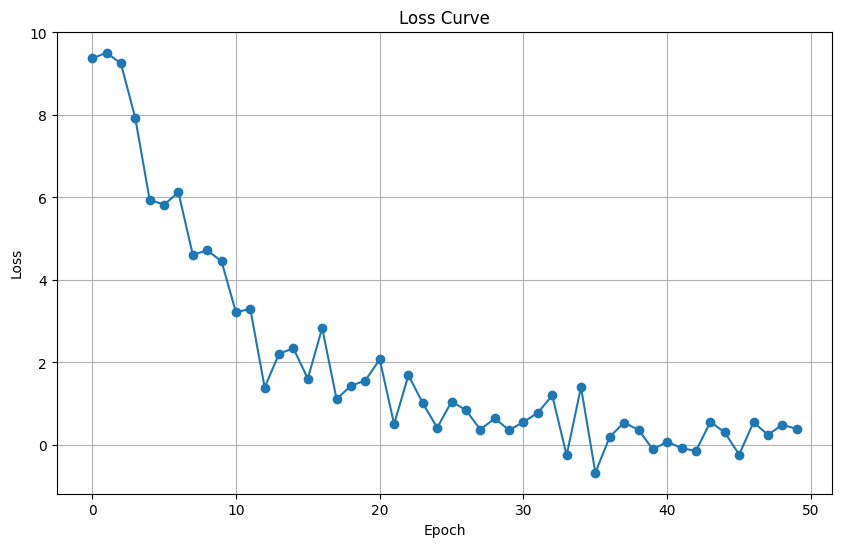

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# 设定初始损失值、学习率和迭代次数
initial_loss = 10
learning_rate = 0.1
iterations = 50

# 定义损失函数递减序列，这里我们使用指数递减，但您可以根据实际情况选择其他递减方式
def decreasing_loss(initial_loss, learning_rate, iterations):
    return initial_loss * np.exp(-learning_rate * np.arange(iterations))

# 生成损失序列
loss_sequence = decreasing_loss(initial_loss, learning_rate, iterations)
# 为损失序列添加噪声
def add_noise(loss_sequence, noise_scale=0.5):
    noise = np.random.normal(0, noise_scale, len(loss_sequence))
    return loss_sequence + noise

# 生成带噪声的损失序列
noisy_loss_sequence = add_noise(loss_sequence)

# 绘制带噪声的损失序列
plt.figure(figsize=(10, 6))
plt.plot(noisy_loss_sequence,marker='o')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()